# 自适应线性单元  &nbsp;&nbsp; ADALINE (Adaptive Linear Neuron)

 $\cdot$ &nbsp;&nbsp; 1962年美国斯坦福大学教授Widrow提出一种自适应可调的神经网络，其基本构成单元称为自适应线性单元，英文缩写为ADALINE
(Adaptive Linear Neuron)  
 $\cdot$ &nbsp;&nbsp; 这种自适应可调的神经网络主要适用于信号处理中的自适应滤波、预测和模式识别.

##  $\cdot$  &nbsp;&nbsp;  ADALINE 模型

 &nbsp;&nbsp;  &nbsp;&nbsp; 在结构上与感知器单元相似   

&nbsp;&nbsp; &nbsp;&nbsp; &nbsp; $\cdot$ &nbsp;&nbsp; 输入向量 ${\boldsymbol{x} = (x_0,x_1,\cdots,x_n)^T}$ 的每个输入分量可以是数字量，也可以是模拟量  
  
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp; $\cdot$ &nbsp;&nbsp; 权值向量 $\boldsymbol{w} = (w_{0},w_{1},\cdots,\cdots,w_{n})^T$

<img src=".\image\adaline.png" alt="ADALINE" width="55%">

### &nbsp;&nbsp;  &nbsp;&nbsp; ADALINE 有两种输出：   

&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; $\cdot$ &nbsp;&nbsp;  当激活函数为线性函数时，输出为模拟量  &nbsp;&nbsp;  &nbsp;&nbsp;   &nbsp;&nbsp;   &nbsp;&nbsp;   &nbsp;&nbsp;  $y = f(\boldsymbol{w}^T\boldsymbol{x}) = \boldsymbol{w}^T\boldsymbol{x}$ 

&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; $\cdot$ &nbsp;&nbsp; 当激活函数为符号函数时，输出为双极性数字量  &nbsp;&nbsp; $o = \mathrm{sgn}(y) =
\begin{cases}
1 & y> 0 \\
-1 & y<0
\end{cases}$  

##  $\cdot$  &nbsp;&nbsp; 学习规则

&nbsp;&nbsp; &nbsp;&nbsp; Widrow-Hoff 学习规则&nbsp; /&nbsp; 最小均方学习规则（Least-Mean-Square，LMS） 

 $$\boldsymbol{w}\leftarrow \boldsymbol{w} + \eta\cdot (d - \boldsymbol{w}^T\boldsymbol{x})\frac{\boldsymbol{x}}{\|\boldsymbol{x}\|^2} \ \ \ \ \ \ \ \ \ \ \ \ \  \varepsilon = d-y = d-\boldsymbol{w}^T\boldsymbol{x} $$

 &nbsp;&nbsp;  &nbsp;&nbsp; $\cdot$  &nbsp;&nbsp; $\varepsilon$的绝对值是单调下降的，$y$总是在不断地接近$d$.  
 &nbsp;&nbsp;  &nbsp;&nbsp;  $\cdot$  &nbsp;&nbsp; LMS算法能保证ADALINE在自适应学习时的收敛性.  
 &nbsp;&nbsp;  &nbsp;&nbsp;  $\cdot$  &nbsp;&nbsp; 该方法的特点就是不需要求导，速度快.  

&nbsp;&nbsp;  &nbsp;&nbsp;<font color="red" size=3> **注：** </font>   &nbsp;&nbsp; <font size=3>权重更新是基于训练集中的所有样本计算，而不是在每个样本之后逐步更新权重，这种方法被称为<font color="blue">**批量梯度下降**</font>. </font>

&nbsp;&nbsp; &nbsp;&nbsp; 对于$N$个输入样本$\{\boldsymbol{x}^{(n)},d^{(n)}\}_{n=1}^{N}$

 $$\boldsymbol{w}\leftarrow \boldsymbol{w} + \eta\cdot \sum_{n=1}^{N}(d^{(n)} - \boldsymbol{w}^T\boldsymbol{x}^{(n)})\boldsymbol{x}^{(n)}$$

In [1]:
import random
import numpy as np
np.set_printoptions(precision=3)
from nn_tool.draw_nn import draw_scores

In [2]:
# 利用 slearn.metrics 定义评价指标 
from sklearn import metrics
# 回归问题评价指标
def mse(preds,target):  
    # 均方误差MSE，即mean squared error
    assert target.shape[0] == preds.shape[0] 
    return metrics.mean_squared_error(target,preds)  

# 分类问题评价指标
# 准确率 Accuracy
def accuracy(preds,labels):
    return metrics.accuracy_score(labels,preds,normalize=False)

#def MSE(y_pred,y):
    # 均方误差
    #return np.mean((y_pred-y)**2)

# 二次损失函数  （ADALINE使用的损失函数）
def quadratic(y,y_pred):
    return np.sum((y-y_pred)**2)/2

In [3]:
# 样本的归一化处理
def normalization(X,scale='norm'):
    # X.shape = [N,M]  N-样本数目 M-特征维度
    if X.ndim == 1:
        X = X.reshape(1,-1)
    if scale == 'min_max':
        X_ = (X.T - np.min(X,axis=1))/(np.max(X,axis=1)-np.min(X,axis=1))
    elif scale == 'z_score':
        X_ = (X.T - np.mean(X,axis=1))/np.std(X,axis=1)
    elif scale == 'norm':
        X_ = X.T/np.linalg.norm(X,axis=1)
    elif scale == 'sigmoid':   # Logistic
        X_ = 1.0 / (1 + np.exp(-X.T))
    return X_.T

In [4]:
# ADALINE 模型
class ADALINE():
    
    def __init__(self,input_size,output_size,init_W=None,init_T=None):
        '''   
        定义 M 输入 L输出-ADALINE
        输入：
            - input_size：输入维度 M
            - output_size：输出维度 L
        '''  
        # 激活函数 感知器 默认为sign函数
        self.input_size = input_size    # 输入数据维度 M
        self.output_size = output_size  # 输出层节点数目 L
        
        # 初始化模型参数
        if init_W is None:
            self.weight = np.random.normal(0.0,1.0,(self.output_size,self.input_size))
        else:
            if not isinstance(init_W,np.ndarray):
                self.weight = np.array(init_W,dtype=np.float64)
            else:
                self.weight = init_W
            if self.weight.ndim <= 1:
                self.weight = self.weight.reshape(1,-1)                
        if init_T is None:
            self.bias = random_gen.normal(0.0,1.0,(1,self.output_size))
        else:
            if not isinstance(init_T,np.ndarray):
                self.bias = np.array(-init_T,dtype=np.float64)
            else:
                self.bias = -init_T            
            if self.bias.ndim <= 1:
                self.bias = self.bias.reshape(-1,1)  
       
    def __call__(self, X):
        # 可以直接调用模型的forward()方法进行前向执行, 
        # 也可以调用__call__(), 从而执行在forward()中定义的前向计算逻辑
        return self.forward(X)
    
    def forward(self,X):    
        # ADALINE 的前向运算
        if X.ndim <= 1: 
            X = X.reshape(1,-1)   # 转成2-维行向量   X.reshape(-1,1) # 转成2-维列向量
        # X.shape  [N,M]   N - 样本数目， M - 特征维数
        net = np.dot(X,self.weight.T) + self.bias    # 净输入
        return net
        
    def update(self,X,y,d,lr,scale=None):
        # X: 输入样本
        # y: 实际输出
        # d: 期望输出
        # lr: 学习率
        # 参数更新
        error = (d - y)   # ADALINE的学习信号
        # 权值更新/偏置更新
        if scale is None:   
            # 样本未进行归一化处理
            # 课本中Adaline的权值更新规则
            X_ = np.insert(X,0,X.shape[0]*[-1],axis=1)
            X_ = X_.T/(np.linalg.norm(X_,axis=1)**2)
            dw = lr*error.T.dot(X_.T)
            self.weight += dw[:,1:]
            self.bias += -dw[:,0]
        else:
            # 样本进行归一化处理后的 权值更新
            self.weight += lr*error.T.dot(X)
            self.bias += lr * error.sum()

In [5]:
class Runner(object):
    
    def __init__(self,model,metric):
        # ADALINE 模型
        self.model = model
        # 评价函数 （e.g. 回归 mse, 分类 acurracy）
        self.metric = metric
        # 记录训练误差
        self.train_loss = []   
        # 记录训练样本评价指标分数
        self.train_score = []
    
    # 模型训练
    def train(self,train_dataset,lr=0.01,epochs=100,**kwargs):  
        # train_dataset 训练数据(X,y)
        # lr 学习率
        # epochs 训练轮数 
        # eps    算法停止条件 (loss < eps)
        eps = kwargs.get('eps',1e-5)        
        # 样本归一化方法
        scale = kwargs.get('scale',None)
        # ADALINE输出信号的类型  离散(类别)信号 digital or 模拟信号 analog（默认）
        out_type = kwargs.get('out_type','analog')  #
        # 打印过程 默认: 循环1轮打印一次
        log_epochs = kwargs.get("log_epochs", 1)  
        
        X,y = train_dataset
        if X.ndim == 1:
            X = X.reshape(1,-1)
        if y.ndim == 1:
            y = y.reshape(-1,1)
        N,M = X.shape    # N - 样本数目  M - 输入维度    
        
        # 样本做 归一化处理
        if scale is not None:
            X = normalization(X,scale=scale)
        
        print('\n初始权值 W(0) = : {}'.format(self.model.weight))
        print('初始阈值T(0) = {}'.format(-self.model.bias))
        
        # 进行num_epochs轮训练        
        for epoch in range(epochs+1): 
            
            # 计算ADALINE输出 o = y_pred
            y_pred = self.model(X)
            
            # 计算训练误差
            loss = quadratic(y_pred,y)
            self.train_loss.append(loss)
            
            # 计算评价指标分数
            score = self.evaluate((X,y),out_type)
            self.train_score.append(score)
            
            # 打印 损失和评价分数
            if (epoch+1) % log_epochs == 0:
                print(f"\n+ 第{epoch+1}步: ") 
                print('- 训练误差(loss/score): %.4f'%loss)
                if out_type in ['class','digital']:
                    print(f"[训练] epoch: {epoch+1}/{epochs}, loss: {round(loss,6)}, score:{score}/{N}")
                else:
                    print(f"[训练] epoch: {epoch+1}/{epochs}, loss: {round(loss,6)}, score:{round(score,6)}")
                
            # 判断算法是否停止(评价模型)
            if loss < eps or epoch == epochs:                
                output = self.predict(X,out_type)
                print('\n 训练结束: ')                
                print(f' - 期望输出: {y.squeeze()}')
                print(f' - 实际输出: {output}')
                if loss < eps:
                    print(f' - 算法迭代次数: {epoch+1}')
                else:
                    print(f' - 算法迭代次数: {epoch}')
                return output
            
            # 更新参数(权值和偏置)
            model.update(X,y_pred,y,lr,scale)
            if (epoch+1) % log_epochs == 0:
                print(' - 更新后的权值 W({}): {}'.format(epoch+1,self.model.weight))
                print(' - 更新后的阈值T({}): {}'.format(epoch+1,-self.model.bias))
    
    # 模型评价
    def evaluate(self,dataset,out_type):        
        X, y = dataset
        # 计算模型输出
        y_pred = self.model(X)
        if out_type in ['digital','class']:
            y_pred = np.sign(y_pred)
        # 计算评价指标
        score = self.metric(y_pred, y)
        return score
        
    # 模型预测    
    def predict(self,X, out_type):
        if out_type in ['digital','class']:
            return np.sign(self.model(X)).squeeze()
        else:
            return self.model(X).squeeze()
        

$\cdot$ &nbsp;&nbsp;&nbsp;P50 例3-4：ADALINE 的 LMS算法的学习步骤.  
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; 输入向量$\boldsymbol{X}=(1.2,2.7)$, $d=2.3$, 初始权值$\boldsymbol{W}(0)=[0.5,1.1]$，初始阈值$T=-1$, 学习率$\eta=0.6$, .


 ADALINE LMS算法的学习步骤

初始权值 W(0) = : [[0.5 1.1]]
初始阈值T(0) = [[-1.]]

+ 第1步: 
- 训练误差(loss/score): 2.5765
[训练] epoch: 1/50, loss: 2.57645, score:5.1529
 - 更新后的权值 W(1): [[0.332 0.722]]
 - 更新后的阈值T(1): [[-0.86]]

+ 第2步: 
- 训练误差(loss/score): 0.4122
[训练] epoch: 2/50, loss: 0.412232, score:0.824464
 - 更新后的权值 W(2): [[0.265 0.571]]
 - 更新后的阈值T(2): [[-0.804]]

+ 第3步: 
- 训练误差(loss/score): 0.0660
[训练] epoch: 3/50, loss: 0.065957, score:0.131914
 - 更新后的权值 W(3): [[0.238 0.51 ]]
 - 更新后的阈值T(3): [[-0.782]]

+ 第4步: 
- 训练误差(loss/score): 0.0106
[训练] epoch: 4/50, loss: 0.010553, score:0.021106
 - 更新后的权值 W(4): [[0.227 0.486]]
 - 更新后的阈值T(4): [[-0.773]]

+ 第5步: 
- 训练误差(loss/score): 0.0017
[训练] epoch: 5/50, loss: 0.001689, score:0.003377
 - 更新后的权值 W(5): [[0.223 0.477]]
 - 更新后的阈值T(5): [[-0.769]]

+ 第6步: 
- 训练误差(loss/score): 0.0003
[训练] epoch: 6/50, loss: 0.00027, score:0.00054
 - 更新后的权值 W(6): [[0.221 0.473]]
 - 更新后的阈值T(6): [[-0.768]]

+ 第7步: 
- 训练误差(loss/score): 0.0000
[训练] epoch: 7/50, loss: 4.3e-05, score:8.6e-0

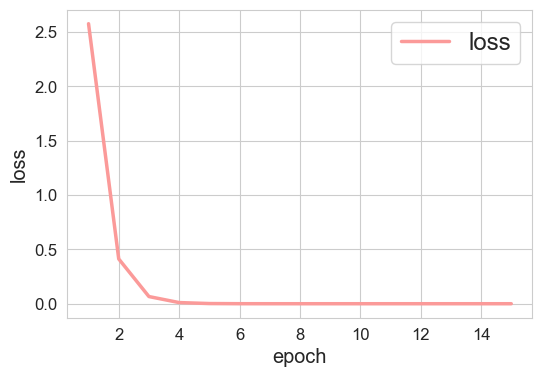

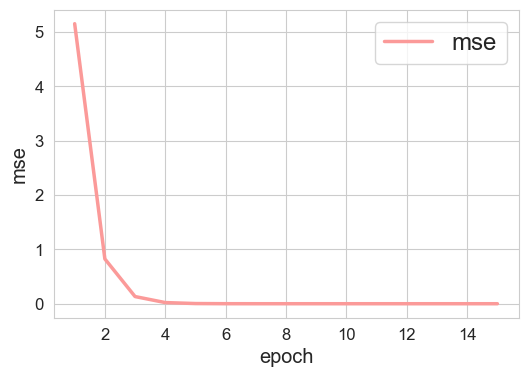

In [6]:
# P50 例3-4
# 输入样本与期望输出
X = np.array([[1.2,2.7]])    
y = np.array([2.3])
train_data = (X,y)
   
# 训练与操作      
print('\n ADALINE LMS算法的学习步骤')
print("================================================================================")

# (1) 模型构建 --- ADALINE模型     
input_size = X.shape[1]
output_size = 1
init_W = [0.5,1.1]
init_T = -1
# 实例化模型
model = ADALINE(input_size,output_size,init_W=init_W,init_T=init_T)   

# (2) 模型训练
# 设置评价函数 
metric = mse  #   MSE函数
# 实例化Runner类, 并传入训练配置    
runner = Runner(model,metric)
# 设置模型训练参数 
lr = 0.6      # 学习率
epochs = 50     # 循环次数 
eps = 1e-10      # 算法停止条件
scale = None   # 'norm'  #    'min_max'  #  'z_score'  # 样本归一化方法
out_type = 'analog'  # 输出类型 离散(类别)信号 'digital/class'  or 模拟信号 'analog'
log_epochs = 1  # 打印轮次

# 开始训练
runner.train(train_data,lr=lr,epochs=epochs,eps=eps,out_type=out_type,scale = scale,log_epochs=log_epochs)
print(" - ADALINE权值W:", model.weight, "阈值T:", -model.bias)

print("\n + 绘制训练损失/评价分数曲线")
# 绘制训练损失曲线
draw_scores(runner.train_loss)
draw_scores(runner.train_score,metric='mse')

print("\n ================================================================================\n")

##  $\cdot$ &nbsp;&nbsp; 单计算节点ADALINE实现二分类问题

$\cdot$ &nbsp;&nbsp;&nbsp;例：将逻辑“与”运算看成一个二分类问题.&nbsp;&nbsp;用感知器学习规则 训练一个分类器,实现“与”运算.  
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;  学习率$\eta=0.05$, 初始权值$\boldsymbol{W}=[0.27,0.07]$，初始阈值$T=0.22$.


训练 ADALINE 实现“与”运算

初始权值 W(0) = : [[0.27 0.07]]
初始阈值T(0) = [[0.22]]

+ 第5步: 
- 训练误差(loss/score): 1.2094
[训练] epoch: 5/50, loss: 1.209371, score:3/4
 - 更新后的权值 W(5): [[0.257 0.103]]
 - 更新后的阈值T(5): [[0.666]]

+ 第10步: 
- 训练误差(loss/score): 1.0596
[训练] epoch: 10/50, loss: 1.059551, score:3/4
 - 更新后的权值 W(10): [[0.337 0.217]]
 - 更新后的阈值T(10): [[0.821]]

+ 第15步: 
- 训练误差(loss/score): 0.9274
[训练] epoch: 15/50, loss: 0.927371, score:3/4
 - 更新后的权值 W(15): [[0.415 0.322]]
 - 更新后的阈值T(15): [[0.913]]

+ 第20步: 
- 训练误差(loss/score): 0.8291
[训练] epoch: 20/50, loss: 0.829122, score:3/4
 - 更新后的权值 W(20): [[0.48  0.408]]
 - 更新后的阈值T(20): [[0.981]]

+ 第25步: 
- 训练误差(loss/score): 0.7590
[训练] epoch: 25/50, loss: 0.75901, score:3/4
 - 更新后的权值 W(25): [[0.533 0.477]]
 - 更新后的阈值T(25): [[1.035]]

+ 第30步: 
- 训练误差(loss/score): 0.7089
[训练] epoch: 30/50, loss: 0.708889, score:4/4
 - 更新后的权值 W(30): [[0.575 0.532]]
 - 更新后的阈值T(30): [[1.078]]

+ 第35步: 
- 训练误差(loss/score): 0.6727
[训练] epoch: 35/50, loss: 0.672684, score:4/4
 - 更新后的权

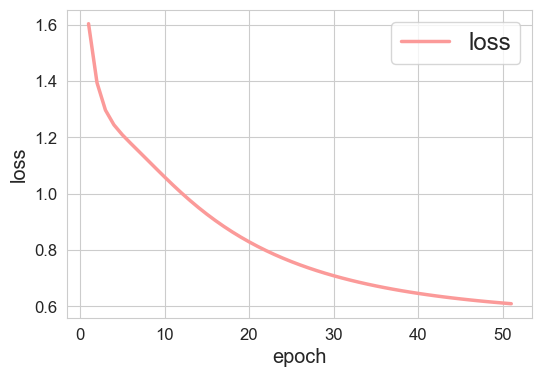

In [7]:
# P50 例3-4
# 输入样本与期望输出
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([-1, -1, -1, 1])
train_data = (X,y)
   
# 训练与操作      
print('\n训练 ADALINE 实现“与”运算')
print("================================================================================")

# (1) 模型构建 --- ADALINE模型     
input_size = X.shape[1]
output_size = 1
# 初始化权值和阈值
init_W = [0.27,0.07]
init_T = 0.22
# 实例化模型
model = ADALINE(input_size,output_size,init_W=init_W,init_T=init_T)   

# (2) 模型训练
# 设置评价函数
metric = accuracy  # 分类问题的评价函数  正确率accuracy
# 实例化Runner类, 并传入训练配置    
runner = Runner(model,metric=metric)
# 模型训练 
lr = 0.1         # 学习率
epochs = 50      # 循环次数 
eps = 1e-5      # 算法停止条件
scale =  None   #  'norm'  #   'min_max'  # 'z_score'  # # 样本归一化方法
out_type = 'class'  # 输出类型 离散(类别)信号 'digital/class'  or 模拟信号 'analog'
log_epochs = 5  # 打印轮次

# 开始训练
runner.train(train_data,lr=lr,epochs=epochs,eps=eps,out_type=out_type,scale = scale,log_epochs=log_epochs)
print(" - ADALINE权值W:", model.weight, "阈值T:", -model.bias)

print("\n + 绘制训练损失曲线")
# 绘制训练损失曲线
draw_scores(runner.train_loss)
print("\n ================================================================================\n")